# Prelogue: Can we predict next BIF game scores?

In [1]:
%%capture --no-stdout
%reload_ext watermark
%watermark -uniz --author "Prayson W. Daniel" -vm -p pymc,polars,altair,seaborn

Author: Prayson W. Daniel

Last updated: 2024-10-05T13:33:27.287607+02:00

Python implementation: CPython
Python version       : 3.12.6
IPython version      : 8.27.0

pymc   : 5.16.2
polars : 1.8.2
altair : 5.4.1
seaborn: 0.13.2

Compiler    : Clang 17.0.6 
OS          : Darwin
Release     : 23.5.0
Machine     : arm64
Processor   : arm
CPU cores   : 16
Architecture: 64bit



## Game Plan
- [ ] Explore data (we might need possession, corners, kicks, stadium size for complex modelling)
- [ ] Re-read:
- - [ ] [Gianluca Baio and Marta Blangiardo. Bayesian hierarchical model for the prediction of football results. Journal of Applied Statistics, 37(2):253–264, 2010.](https://discovery.ucl.ac.uk/id/eprint/16040/1/16040.pdf)
-  - [ ] [Modelling Association Football Scores and Inefficiencies in the Football Betting Market - Dixon, Mark J. AU - Coles, Stuart G.](https://academic.oup.com/jrsssc/article/46/2/265/6990546)
- [ ] Data Prepration (Encoding, later attendance/stadium_capacity)
- [ ] Build a Model:
- - [ ]  loop [Prior knowledge, create/update model, evaluate prior]
 
### Choices:
`Recent games data`:  Dixon and Coles' time decaying as adjustment factor  won't be necessary <br>
`Bayesian modelling` : Accounts for score dependibiblity

# Chapter One: Data

In [2]:
from pathlib import Path
import json

data = json.loads(Path("../data/data.json").read_text())

In [3]:
import polars as pl

In [4]:
# SuperLiga 2023-present (October 28 10:15)
# {"Runde": 1, "Date": "Fre 21/07/2023", "Time": "19.00", "Match": "FCM-HIF", "Score": "1-0", "Attendance": "7.846", "Referee": "Mads Kristoffersen"}
superliga = (
    pl.DataFrame(data)
      .with_columns([pl.col("Attendance").str.replace_all(".", "", literal=True).cast(pl.Int32).alias("attendance"),
                     pl.concat_str(["Date", "Time"], separator=" ")
                        .str.slice(4) # remove danish days of the week (Fre, Tor ...)
                        .str.strptime(pl.Datetime, format="%d/%m/%Y %H.%M")
                        .alias("game_date"), 
                    pl.col("Match").str.split("-").list.get(0).alias("home"),
                    pl.col("Match").str.split("-").list.get(1).alias("away"),
                    pl.col("Score").str.split("-").list.get(0).cast(pl.Int16).alias("home_goals"),
                    pl.col("Score").str.split("-").list.get(1).cast(pl.Int16).alias("away_goals"),
                    ])
    .drop(["Date", "Time", "Match", "Score", "Attendance"])
    .select([pl.col("Runde").alias("round"), "game_date","home", "away", "home_goals", "away_goals", "Referee", "attendance"])
)

In [5]:
print(superliga)

shape: (444, 8)
┌───────┬──────────────┬──────┬──────┬────────────┬────────────┬──────────────────────┬────────────┐
│ round ┆ game_date    ┆ home ┆ away ┆ home_goals ┆ away_goals ┆ Referee              ┆ attendance │
│ ---   ┆ ---          ┆ ---  ┆ ---  ┆ ---        ┆ ---        ┆ ---                  ┆ ---        │
│ i64   ┆ datetime[μs] ┆ str  ┆ str  ┆ i16        ┆ i16        ┆ str                  ┆ i32        │
╞═══════╪══════════════╪══════╪══════╪════════════╪════════════╪══════════════════════╪════════════╡
│ 1     ┆ 2022-07-15   ┆ FCM  ┆ RFC  ┆ 1          ┆ 1          ┆ Jonas Hansen         ┆ 7359       │
│       ┆ 19:00:00     ┆      ┆      ┆            ┆            ┆                      ┆            │
│ 1     ┆ 2022-07-17   ┆ VFF  ┆ AaB  ┆ 2          ┆ 1          ┆ Mads Kristoffersen   ┆ 4681       │
│       ┆ 14:00:00     ┆      ┆      ┆            ┆            ┆                      ┆            │
│ 1     ┆ 2022-07-17   ┆ LBK  ┆ SIF  ┆ 2          ┆ 2          ┆ Mikkel Red

In [6]:
# drop last game as the anlysis was done before 2024-09-30
superliga = superliga.slice(0, len(superliga)-1)

# Chapter Two: EDA

In [7]:
import altair as alt
import seaborn as sns
import arviz as az
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = "retina"
# ArviZ ships with style sheets!
az.style.use("arviz-darkgrid")
# az.rcParams["stats.ci_prob"] = 0.90

In [8]:
title = alt.TitleParams('Brøndby IF Goals Difference', 
                        subtitle="Home vs Away (2022 - )",
                        anchor='start',
                        color="blue",
                        subtitleColor="light bluey",
                        fontSize=18,
                        
                        )

# https://vega.github.io/vega/docs/schemes/#reference
# color = alt.Color('win', scale=alt.Scale(scheme='accent'))
color = alt.Color('win',
                scale=alt.Scale(
                        domain=['won', 'lost'],
                        range=['green', 'red']),
                 legend=None,
                 )

brush = alt.selection_interval(encodings=['y'])

In [9]:
home = (superliga
   .filter(pl.col("home") == "BIF")
   .select(["away", "home_goals", "away_goals"])
   .group_by("away", maintain_order=True).sum()
   .with_columns(
       pl.col("home_goals").sub(pl.col("away_goals")).alias("goals"),
   )
   .with_columns(
    pl.when(pl.col('goals') > 0).then(pl.lit("won")).otherwise(pl.lit("lost")).alias('win'),
   )
   .sort("away")
   .plot.bar(
       x="away",
       y=alt.Y('goals', axis=alt.Axis(labels=True, offset=-1), title='Goals'),
       color=color,

    )
    .properties(
        title=title,
        width=400,
        height=400,

        
    )
        
)

away = (superliga
   .filter(pl.col("away") == "BIF")
   .select(["home", "home_goals", "away_goals"])
   .group_by("home", maintain_order=True).sum()
   .with_columns(
       pl.col("away_goals").sub(pl.col("home_goals")).alias("goals"),
       
   )
   .with_columns(
    pl.when(pl.col('goals') > 0).then(pl.lit("won")).otherwise(pl.lit("lost")).alias('win'),
   )
   .sort("home")
   .plot.bar(
       x="home",
       y=alt.Y('goals', axis=alt.Axis(labels=False), title=''),
       color=color,
       

    )
    .properties(
        width=400,
        height=400,
        
    )
)

In [10]:
alt.hconcat(home, away).resolve_scale(x="shared", y ="shared")

alt.HConcatChart(...)

### What the ... Home Advantange

In [11]:
# does BIF win more at home than away? Is there a home advantage?

TEAM_NAME = "BIF"
(
    superliga
    .select(
        pl.when(pl.col("home") == TEAM_NAME)
        .then(pl.when(pl.col("home_goals") > pl.col("away_goals")).then(1).otherwise(0))
        .mean()
        .alias("home_rate"),
        
        pl.when(pl.col("away") == TEAM_NAME)
        .then(pl.when(pl.col("home_goals") < pl.col("away_goals")).then(1).otherwise(0))
        .mean()
        .alias("away_rate")
    )
)

home_rate,away_rate
f64,f64
0.5,0.432432


In [12]:
# What is home and away goals rates when BIF plays?
(
    superliga
      .filter((pl.col("home").eq(TEAM_NAME) | pl.col("away").eq(TEAM_NAME)))
      .select(pl.col("home_goals"), pl.col("away_goals"))
      .mean()

)

home_goals,away_goals
f64,f64
1.534247,1.575342


In [13]:
# Is there a general home advantage?

(
    superliga
    .select(
        pl.when(pl.col("home_goals") > pl.col("away_goals")).then(1).otherwise(0)
        .mean()
        .alias("home_rate"),
        pl.when(pl.col("home_goals") < pl.col("away_goals")).then(1).otherwise(0)
        .mean()
        .alias("away_rate")
    )
    
)

home_rate,away_rate
f64,f64
0.408578,0.322799


In [14]:
# What is a general home and away goals rates?
(
    superliga
      .select(pl.col("home_goals"), pl.col("away_goals"))
      .mean()

)

home_goals,away_goals
f64,f64
1.489842,1.354402


### What the ... Goals Distribution

In [15]:
PLAYED_MATCHES = superliga.shape[0]

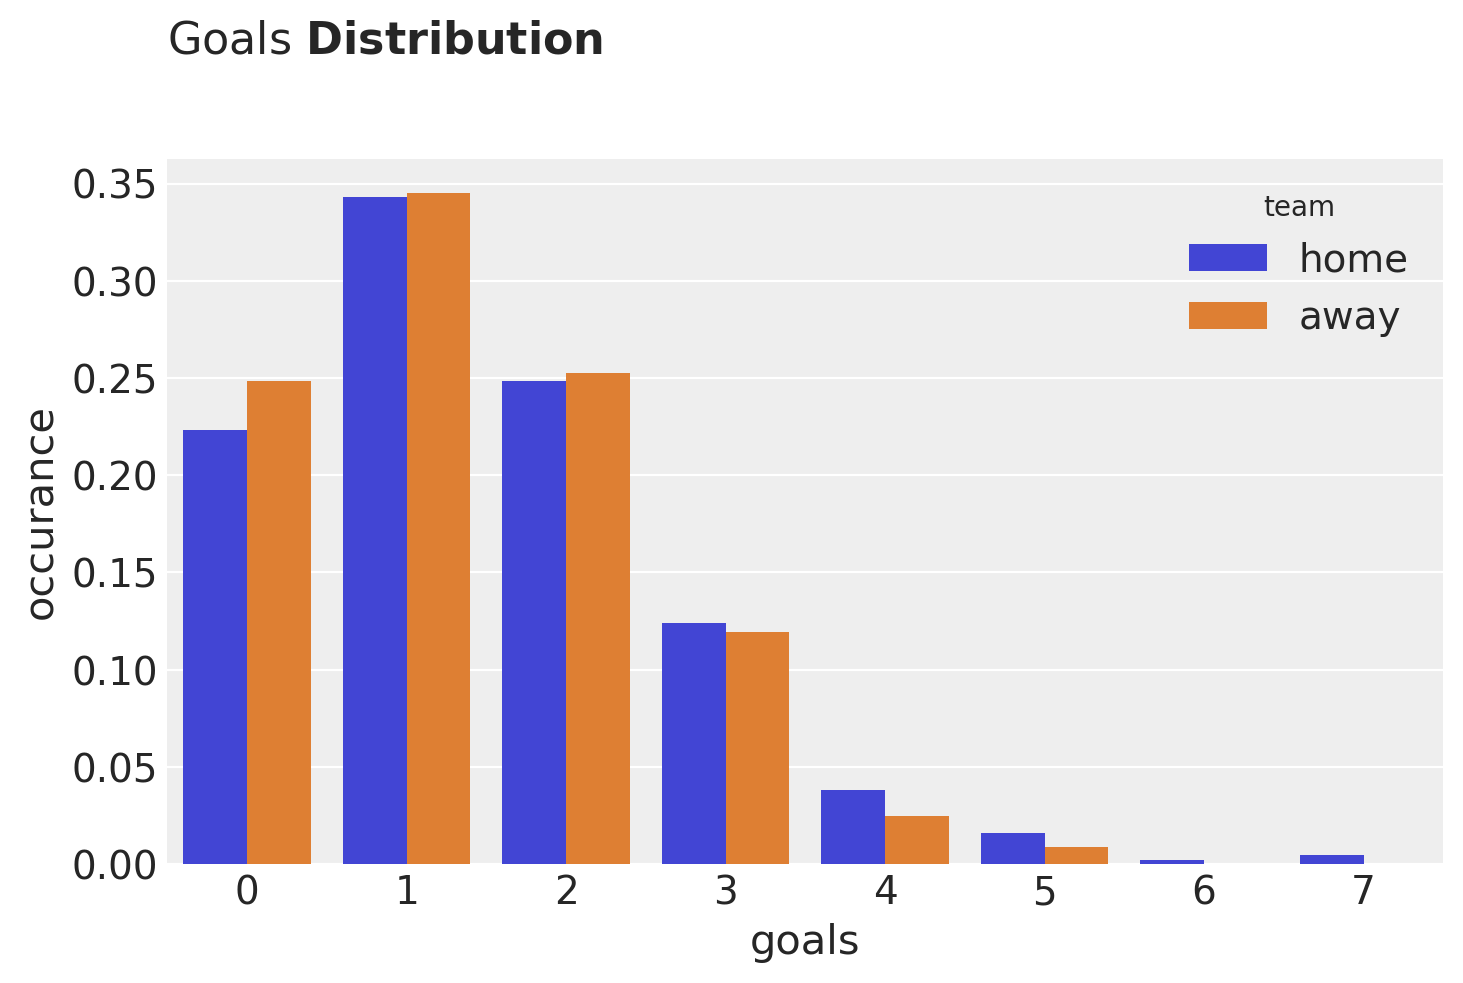

In [16]:
 goals = (superliga
     .unpivot(on=["home_goals", "away_goals"], variable_name="team", value_name="goals")
     .with_columns(pl.col("team").str.slice(0, length=4))
     .group_by(pl.col("team"), pl.col("goals")) 
     .agg(pl.len().alias("occurance") / PLAYED_MATCHES)
     .sort(pl.col("goals"))
)

_, ax = plt.subplots()
ax.set_title("Goals $\\bf{Distribution}$ \n", fontsize=16, loc="left", pad=20, y=1.0)
_ = sns.barplot(
   goals,
    x = "goals",
    y = "occurance",
    hue= "team",

)

# Chapter Three: Modeling

Poisson Distribution

```python
# Simple model

goals_home = home_advantage + home_attack + defence_away
goals_away = away_attack + defence_home

# add referee effect
goals_home = home_advantage + referee + home_attack + defence_away
goals_away = away_attack + referee + defence_home
```

In [17]:
import pytensor.tensor as pt
import pymc as pm
import numpy as np

In [18]:
## Data Preparation

liga = (superliga
 .with_columns(
     pl.col("home").rank("dense").sub(1).alias("home_enc"), 
     pl.col("away").rank("dense").sub(1).alias("away_enc"),
    )
)

liga

round,game_date,home,away,home_goals,away_goals,Referee,attendance,home_enc,away_enc
i64,datetime[μs],str,str,i16,i16,str,i32,u32,u32
1,2022-07-15 19:00:00,"""FCM""","""RFC""",1,1,"""Jonas Hansen""",7359,5,10
1,2022-07-17 14:00:00,"""VFF""","""AaB""",2,1,"""Mads Kristoffersen""",4681,14,2
1,2022-07-17 14:00:00,"""LBK""","""SIF""",2,2,"""Mikkel Redder""",3871,8,11
1,2022-07-17 16:00:00,"""FCK""","""ACH""",0,1,"""Jakob Kehlet""",22184,4,0
1,2022-07-17 18:00:00,"""BIF""","""AGF""",1,0,"""Sandi Putros""",17022,3,1
…,…,…,…,…,…,…,…,…,…
10,2024-09-28 16:00:00,"""AGF""","""RFC""",2,2,"""Jakob A. Sundberg""",13280,1,10
10,2024-09-29 14:00:00,"""AaB""","""SJF""",3,0,"""Mads Kristoffersen""",6802,2,12
10,2024-09-29 14:00:00,"""FCM""","""VFF""",3,1,"""Lasse Læbel Graagaard""",11355,5,14


In [19]:
teams = liga["home"].unique(maintain_order=True).sort().to_numpy()
home_team = liga["home_enc"].to_numpy()
away_team = liga["away_enc"].to_numpy()

home_goals = liga["home_goals"].to_numpy()
away_goals = liga["away_goals"].to_numpy()

In [20]:
coords = {"teams": teams}
n_teams = len(teams)

In [21]:
with pm.Model(coords=coords) as m:

    home_advantage = pm.Normal('home_advantage', mu=0, sigma=.5)
    
    # team-specific parameters
    attack_strength = pm.Normal('attack_strength', mu=0, sigma=.5, shape=n_teams, dims="teams")
    defense_strength = pm.Normal('defense_strength', mu=0, sigma=.5, shape=n_teams, dims="teams")

    # Expected goals for home and away teams
    theta_home = pm.Deterministic('theta_home', 
                                  pt.exp(home_advantage +
                                              attack_strength[home_team] - 
                                              defense_strength[away_team]
                                             ), )
    
    theta_away = pm.Deterministic('theta_away', 
                                  pt.exp(attack_strength[away_team] - 
                                              defense_strength[home_team]), )
   

    

        # Observations
    home_goals_obs = pm.Poisson('home_goals_obs', mu=theta_home, observed=home_goals)
    away_goals_obs = pm.Poisson('away_goals_obs', mu=theta_away, observed=away_goals)

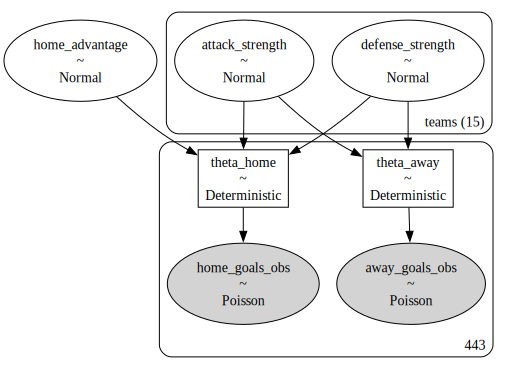

In [22]:
pm.model_to_graphviz(m)

In [23]:
with m:
    trace = pm.sample(2000, tune=1000, target_accept=0.95, return_inferencedata=True)

Sampling 4 chains, 0 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:00:03

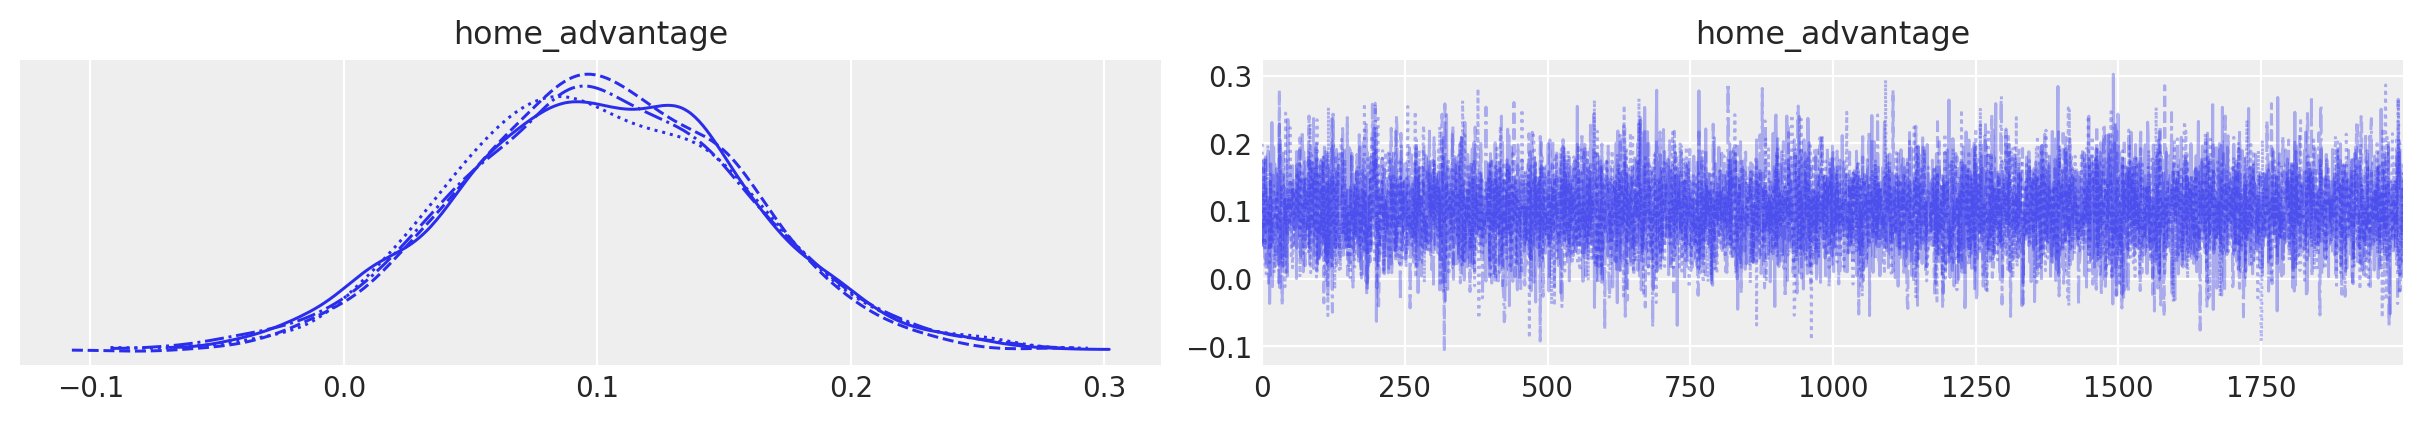

In [24]:
az.plot_trace(trace, var_names=['home_advantage']);

In [25]:
az.summary(trace, var_names=['home_advantage', 'attack_strength', 'defense_strength'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
home_advantage,0.101,0.056,-0.005,0.206,0.001,0.000,10367.0,5686.0,1.0
attack_strength[ACH],-0.109,0.187,-0.468,0.234,0.003,0.002,3321.0,4592.0,1.0
attack_strength[AGF],0.233,0.133,-0.012,0.486,0.003,0.002,1766.0,3686.0,1.0
attack_strength[AaB],-0.107,0.167,-0.424,0.201,0.003,0.002,2869.0,4354.0,1.0
attack_strength[BIF],0.423,0.128,0.171,0.644,0.003,0.002,1604.0,3547.0,1.0
attack_strength[FCK],0.520,0.123,0.283,0.744,0.003,0.002,1583.0,3231.0,1.0
attack_strength[FCM],0.465,0.125,0.223,0.694,0.003,0.002,1572.0,2913.0,1.0
attack_strength[FCN],0.405,0.128,0.167,0.652,0.003,0.002,1651.0,3206.0,1.0
attack_strength[HIF],-0.286,0.200,-0.681,0.068,0.003,0.002,3964.0,4681.0,1.0
attack_strength[LBK],-0.132,0.144,-0.394,0.148,0.003,0.002,2021.0,3794.0,1.0


In [26]:
with m:
    ppc = pm.sample_posterior_predictive(trace, extend_inferencedata=True)

Sampling ... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:00:00

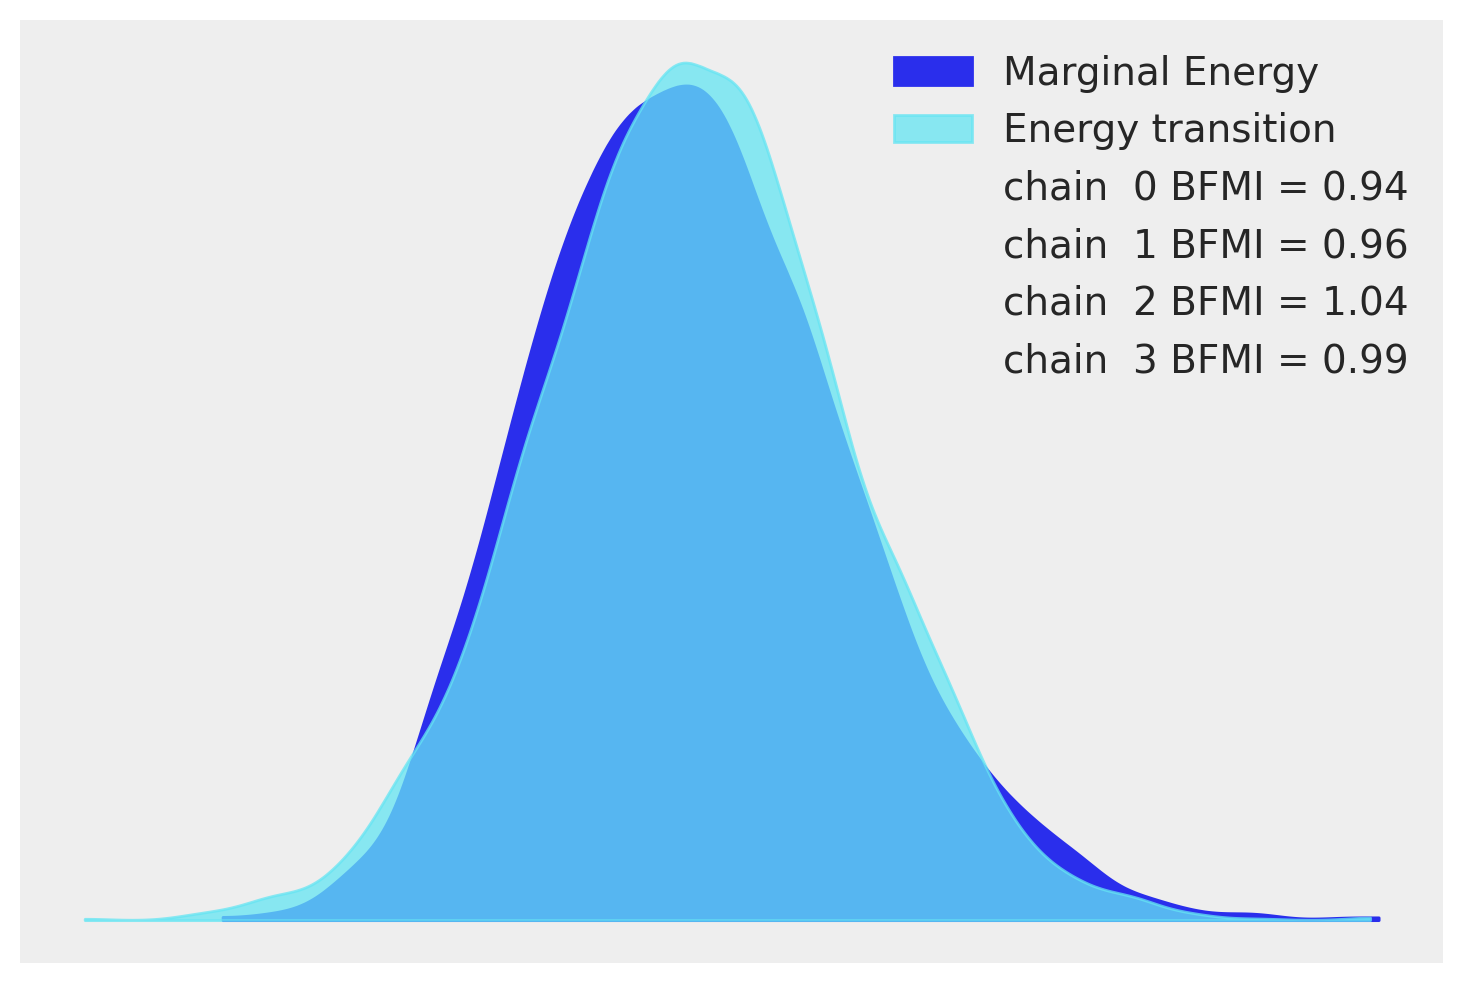

In [27]:
az.plot_energy(trace);

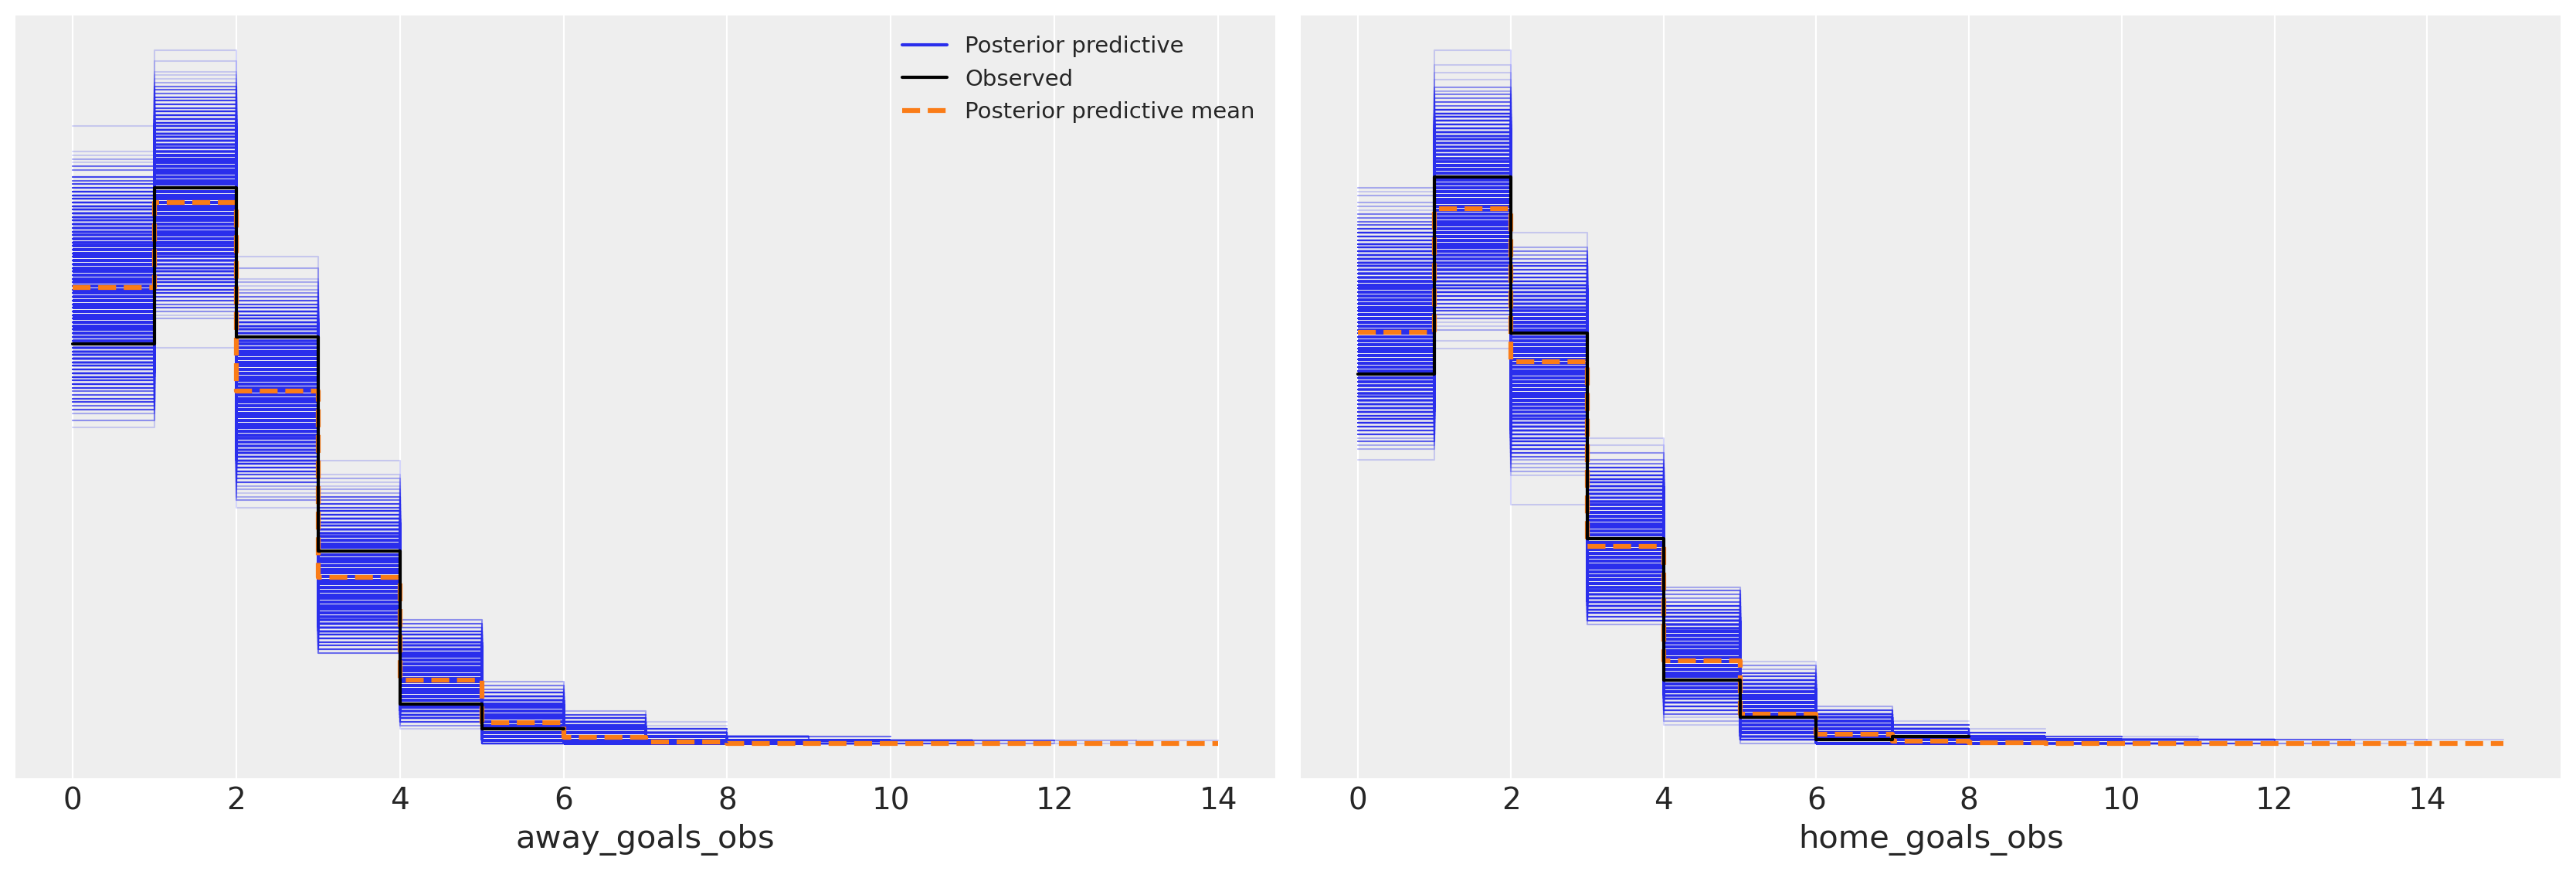

In [28]:
az.plot_ppc(ppc);

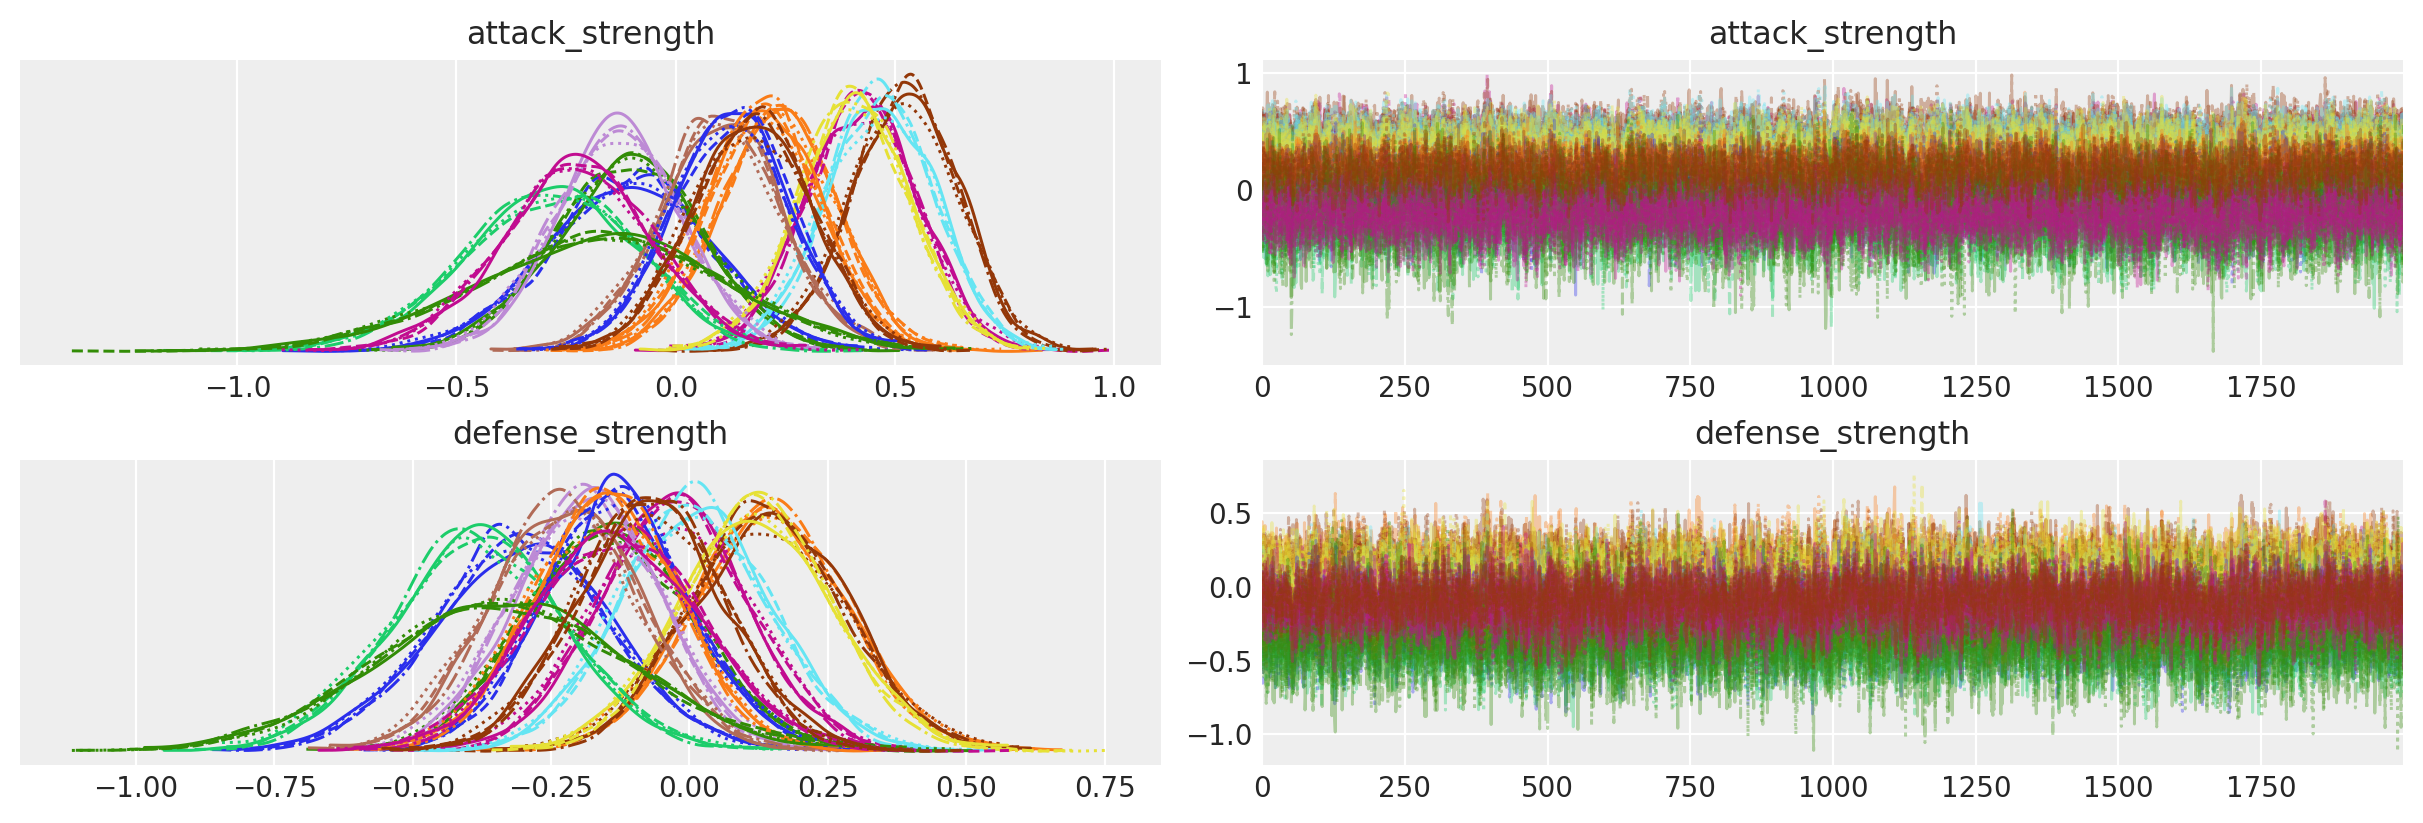

In [29]:
with m:
    pm.plot_trace(trace, var_names=["attack_strength", "defense_strength"]);

In [30]:
from predictor import SuperLigaPredictor


In [31]:
predictor = SuperLigaPredictor(trace, teams)

In [32]:
predictor.predict_match(home_team="FCN", away_team="BIF")

{'home_team': 'FCN',
 'away_team': 'BIF',
 'probabilities': {'home_win': 0.45925, 'draw': 0.23825, 'away_win': 0.3025},
 'expected_goals': {'FCN': 1.7250726819103284, 'BIF': 1.3646918941757953}}

In [33]:
predictor.print_prediction(predictor.predict_match(home_team="FCN", away_team="BIF"))

Predicted probabilities for FCN vs BIF:
Home win probability: 46.08%
Draw probability: 23.49%
Away win probability: 30.44%

Expected goals:
FCN: 1.73
BIF: 1.36


In [34]:
# Next Game BIF vs FCM

In [35]:
predictor.print_prediction(predictor.predict_match(home_team="BIF", away_team="FCM"))

Predicted probabilities for BIF vs FCM:
Home win probability: 40.26%
Draw probability: 22.55%
Away win probability: 37.19%

Expected goals:
BIF: 1.69
FCM: 1.66
